# Notebook to apply hillshade model correction to Planet images at Wolverine Glacier, AK

GEOPH 520: DSP

Rainey Aberle

April 2022


### Outline

1. Initial setup:
    - Import packages
    - Define paths in directory
2. Load WorldView-derived DEM and Planet images
3. Create hillshade model
4. Resample hillshade to image coordinates
5. Determine optimal band scalars for correction, apply correction to image

## 1. Initial Setup

In [1]:
# -----Import packages
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import geopandas as gpd
from functions import sunpos
from shapely.geometry import Polygon
import subprocess
from scipy.interpolate import interp2d
from scipy import interpolate
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt2d

In [2]:
# -----Define paths in directory
# path to DEM
DEM_path = '/Users/raineyaberle/Research/PhD/Wolverine/DEMs/WG_20200728-DEM_mosaic_crop_UTM6_resamp_filled.tif'
# path to Planet images
im_path = '/Users/raineyaberle/Research/PhD/Wolverine/imagery/Planet/2021-04-20_2021-08-25/PSScene4Band/'
# AOI, i.e. glacier outline (if desired)
AOI_path = '/Users/raineyaberle/Research/PhD/Wolverine/GIS_data/wolverine_RGI.shp'
# output folder
out_path = im_path+'../'
# test results output folder (if outputting all scalar tests)
results_path = out_path+'hillshade-correction-tests/'

In [3]:
# -----Fill DEM holes here by uncommenting:
# DEM_nodata = np.where(DEM.read(1)==0, np.nan, DEM.read(1))
# DEM_filled_fn = '/Users/raineyaberle/Research/PhD/Wolverine/DEMs/WG_20200728-DEM_mosaic_crop_UTM6_resamp_filled.tif'
# x = np.arange(0, DEM_nodata.shape[1])
# y = np.arange(0, DEM_nodata.shape[0])
# # mask invalid values
# array = np.ma.masked_invalid(DEM_nodata)
# xx, yy = np.meshgrid(x, y)
# #get only the valid values
# x1 = xx[~array.mask]
# y1 = yy[~array.mask]
# newarr = array[~array.mask]
# DEM_filled = interpolate.griddata((x1, y1), newarr.ravel(),
#                           (xx, yy),
#                              method='cubic')

# # plot
# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
# ax1.imshow(DEM.read(1))
# ax2.imshow(DEM_filled)
# plt.show()

# # save to file
# with rio.open(DEM_filled_fn,'w', 
#               driver='GTiff', 
#               height=DEM_filled.shape[0], 
#               width=DEM_filled.shape[1], 
#               dtype=DEM_filled.dtype,
#               count=1,
#               crs=DEM.crs,
#               transform=DEM.transform) as dst:
#     dst.write(DEM_filled, 1)
#     print('DEM saved to file:')
#     print('    ',DEM_filled_fn)

## 2. Load WorldView-derived DEM and Planet images

DEM CRS:  EPSG:32606
Planet CRS: EPSG:32606
AOI CRS: epsg:32206


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


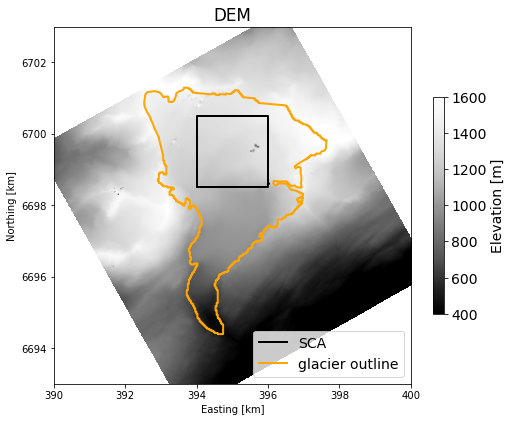

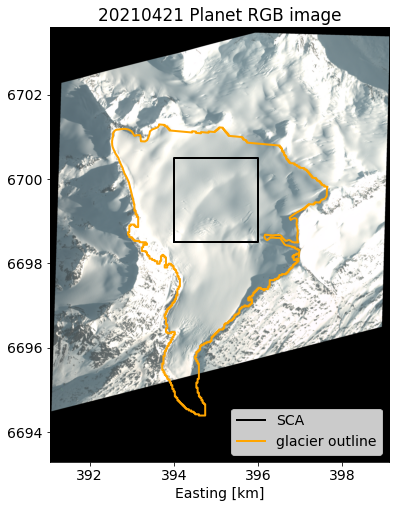

In [4]:
# -----Define CRS (EPSG code)
crs = 32206

# -----Load DEM
DEM = rio.open(DEM_path)
# coordinates
DEM_x = np.linspace(DEM.bounds.left, DEM.bounds.right, num=np.shape(DEM.read(1))[1])
DEM_y = np.linspace(DEM.bounds.top, DEM.bounds.bottom, num=np.shape(DEM.read(1))[0])

# -----Load images
ims = os.chdir(im_path) # change directory
im_names = glob.glob('*SR_clip.tif') # load all .tif file names
im_names.sort() # sort file names by date
# load second image
im_name = im_names[1]
im = rio.open(im_name)
# load bands (blue, green, red, near infrared)
b = im.read(1).astype(float) /10000 
g = im.read(2).astype(float) /10000 
r = im.read(3).astype(float) /10000 
nir = im.read(4).astype(float) /10000  
# coordinates
im_x = np.linspace(im.bounds.left, im.bounds.right, num=np.shape(b)[1])
im_y = np.linspace(im.bounds.top, im.bounds.bottom, num=np.shape(b)[0])

# -----Define snow-covered area
SCA = Polygon([(394e3, 6698.5e3), (394e3, 6700.5e3), (396e3, 6700.5e3), (396e3, 6698.5e3), (394e3, 6698.5e3)])

# -----Define Area of Interest (AOI) - used for image clipping
AOI = gpd.read_file(AOI_path)
AOI = AOI.to_crs(crs)

# print coordinate information
print('DEM CRS: ',DEM.crs)
print('Planet CRS:',rio.open(im_names[0]).crs)
print('AOI CRS:',AOI.crs)

# -----plot DEM and Planet image
fig1, ax1 = plt.subplots(1, 1, figsize=(8,8))
plt.rcParams.update({'font.size': 14, 'font.serif': 'Arial'})
# DEM
DEM_plot = ax1.imshow(DEM.read(1), extent=(np.min(DEM_x)/10**3, np.max(DEM_x)/10**3, np.min(DEM_y)/10**3, np.max(DEM_y)/10**3),
                      cmap='Greys_r', clim=(400,1600))
ax1.plot([x/1000 for x in SCA.exterior.xy[0]], [y/1000 for y in SCA.exterior.xy[1]], 
         '-k', linewidth=2, label='SCA')
ax1.plot([x[0]/1000 for x in list(AOI.exterior[0].coords)], [x[1]/1000 for x in list(AOI.exterior[0].coords)], 
         '-', color='orange', linewidth=2, label='glacier outline')
ax1.set_title('DEM')
ax1.set_xlabel('Easting [km]')
ax1.set_ylabel('Northing [km]')
ax1.set_xlim(390, 400)
ax1.set_ylim(6693, 6703)
ax1.legend(loc='lower right')
# colorbar
fig1.colorbar(DEM_plot, ax=ax1, location='right', shrink=0.5, label='Elevation [m]')
# Planet image
fig2, ax2 = plt.subplots(1, 1, figsize=(8,8))
plt.rcParams.update({'font.size': 14, 'font.serif': 'Arial'})
im = rio.open(im_names[1])
b_plot = ax2.imshow(np.dstack([r, g, b]), 
                    extent=(np.min(im_x)/10**3, np.max(im_x)/10**3, np.min(im_y)/10**3, np.max(im_y)/10**3))
ax2.plot([x/1000 for x in SCA.exterior.xy[0]], [y/1000 for y in SCA.exterior.xy[1]], 
         '-k', linewidth=2, label='SCA')
ax2.plot([x[0]/1000 for x in list(AOI.exterior[0].coords)], [x[1]/1000 for x in list(AOI.exterior[0].coords)], 
         '-', color='orange', linewidth=2, label='glacier outline')
ax2.set_title(im_names[1][0:8]+' Planet RGB image')
ax2.legend(loc='lower right')
ax2.set_xlabel('Easting [km]')
plt.show()

## 3. Create hillshade model

Image name:
     20210421_165659_0f21_3B_AnalyticMS_SR_clip.tif
azimuth:  97.63 elevation: 18.28
hillshade model already exists in directory:
     /Users/raineyaberle/Research/PhD/Wolverine/imagery/Planet/2021-04-20_2021-08-25/PSScene4Band/../hillshades/97.63-az_18.28-z_hillshade_WV.tif
hillshade loaded


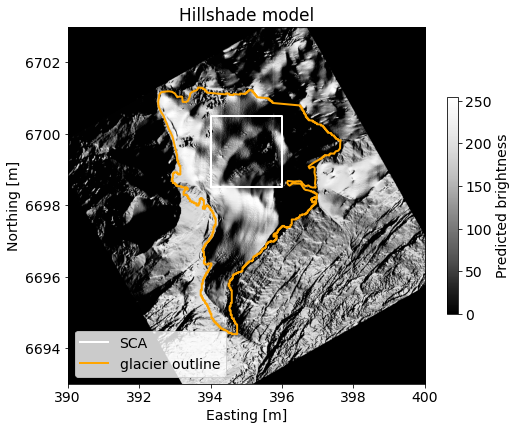

In [5]:
# -----location coordinates (can be approximate)
location = (60.401211, -148.910267)

# -----extract datetime from image name
print('Image name:')
print('    ',im_name)
# when = year, month, day, hour, minute, second
when = (float(im_name[0:4]), float(im_name[4:6]), float(im_name[6:8]), 
        float(im_name[9:11]), float(im_name[11:13]), float(im_name[13:15]))
    
# -----extract sun azimuth and elevation
azimuth, elevation = sunpos(when, location, refraction=1)
print('azimuth: ',azimuth, 'elevation:',elevation)

# -----create hillshade model if it does not exist
hs_fn = out_path+'hillshades/'+str(azimuth)+'-az_'+str(elevation)+'-z_hillshade_WV.tif'
if os.path.exists(hs_fn):
    print('hillshade model already exists in directory:')
    print('    ',hs_fn)
else:
    print('creating hillshade model...')
    # construct the gdal_merge command
    # modified from: https://github.com/clhenrick/gdal_hillshade_tutorial
    # gdaldem hillshade -az aximuth -z elevation dem.tif hillshade.tif
    cmd = 'gdaldem hillshade -az '+str(azimuth)+' -z '+str(elevation)+' '+str(DEM_path)+' '+hs_fn
    # run the command 
    p = subprocess.run(cmd, shell=True, capture_output=True) 
    print(p)
    print(' ')

# -----load hillshade model from file
hs = rio.open(hs_fn)
print('hillshade loaded')
# coordinates
hs_x = np.linspace(hs.bounds.left, hs.bounds.right, num=np.shape(hs.read(1))[1])
hs_y = np.linspace(hs.bounds.top, hs.bounds.bottom, num=np.shape(hs.read(1))[0])

# -----plot
fig, (ax1) = plt.subplots(1, 1, figsize=(8,8))
plt.rcParams.update({'font.size': 14, 'font.serif': 'Arial'})
# hillshade
hs_im = ax1.imshow(np.flipud(hs.read(1)), cmap='Greys_r', origin='lower', 
           extent=(np.min(hs_x)/1000, np.max(hs_x)/1000, np.min(hs_y)/1000, np.max(hs_y)/1000))
ax1.plot([x/1000 for x in SCA.exterior.xy[0]], [y/1000 for y in SCA.exterior.xy[1]], 
         '-w', linewidth=2, label='SCA')
ax1.plot([x[0]/1000 for x in list(AOI.exterior[0].coords)], [x[1]/1000 for x in list(AOI.exterior[0].coords)], 
         '-', color='orange', linewidth=2, label='glacier outline')
ax1.set_title('Hillshade model')
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.set_xlim(390, 400)
ax1.set_ylim(6693, 6703)
ax1.legend(loc='lower left')
fig.colorbar(hs_im, ax=ax1, shrink=0.5, label='Predicted brightness')
plt.show()

## 4. Resample hillshade to image coordinates (or load resampled hillshade from file)

In [6]:
# resampled hillshade file name
hs_resamp_fn = out_path+'hillshades/'+str(azimuth)+'-az_'+str(elevation)+'-z_hillshade_resamp_WV.tif'
# check if file already exists in directory
if os.path.exists(hs_resamp_fn):
    print('resampled hillshade exists in directory:')
    print('    ',hs_resamp_fn)
# resample if it doesn't exist
else:
    print('resampling hillshade...')
    # create interpolation object
    f = interp2d(hs_x, hs_y, hs.read(1))
    # initialize
    hs_resamp = np.zeros(np.shape(b))
    # loop through image coordinates
    for i in np.arange(0,len(im_x)-1):
        for j in np.arange(0,len(im_y)-1):
            hs_resamp[j,i] = f(im_x[i], im_y[j])
    # save to file
    with rio.open(hs_resamp_fn,'w',
                  driver='GTiff',
                  height=hs_resamp.shape[0],
                  width=hs_resamp.shape[1],
                  dtype=hs_resamp.dtype,
                  count=1,
                  crs=im.crs,
                  transform=im.transform) as dst:
        dst.write(hs_resamp, 1)
    print('resampled hillshade saved to file:')
    print('    ',hs_resamp_fn)

# -----load resampled hillshade
hs_resamp = rio.open(hs_resamp_fn).read(1)
print('reasmpled hillshade hillshade loaded')

# -----apply a Gaussian smoothing filter
# scipy.ndimage.gaussian_filter(input, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
hs_resamp_smooth = gaussian_filter(hs_resamp, sigma=3)
print('resampled hillshade filtered')

resampled hillshade exists in directory:
     /Users/raineyaberle/Research/PhD/Wolverine/imagery/Planet/2021-04-20_2021-08-25/PSScene4Band/../hillshades/97.63-az_18.28-z_hillshade_resamp_WV.tif
reasmpled hillshade hillshade loaded
resampled hillshade filtered


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


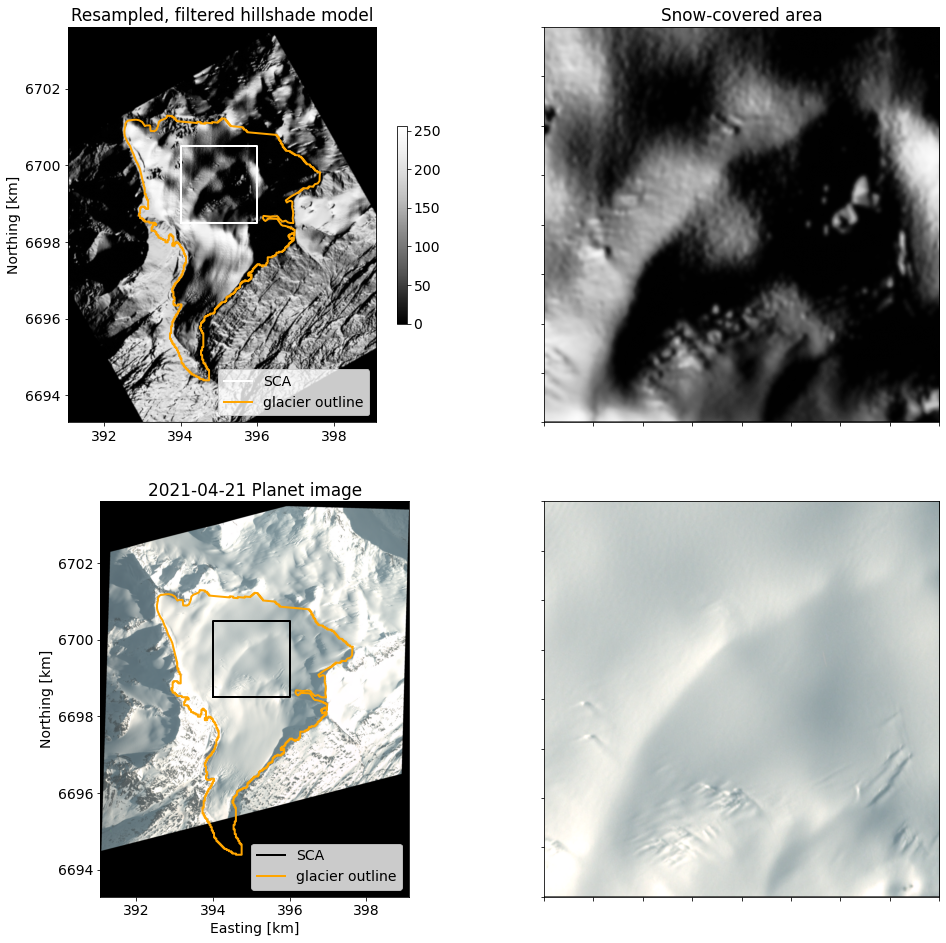

In [7]:
# -----clip image and hillshade to SCA
# image
Ix = np.where((im_x >= SCA.bounds[0]) & (im_x <= SCA.bounds[2]))[0]
Iy = np.where((im_y >= SCA.bounds[1]) & (im_y <= SCA.bounds[3]))[0]
b_SCA = np.zeros((np.shape(Ix)[0], np.shape(Iy)[0]))
g_SCA = np.zeros((np.shape(Ix)[0], np.shape(Iy)[0]))
r_SCA = np.zeros((np.shape(Ix)[0], np.shape(Iy)[0]))
nir_SCA = np.zeros((np.shape(Ix)[0], np.shape(Iy)[0]))
hs_SCA = np.zeros((np.shape(Ix)[0], np.shape(Iy)[0]))
for i in np.arange(0,np.shape(Ix)[0]-1):
    for j in np.arange(0, np.shape(Iy)[0]-1):
        b_SCA[j,i] = b[Iy[j], Ix[i]]
        g_SCA[j,i] = g[Iy[j], Ix[i]]
        r_SCA[j,i] = r[Iy[j], Ix[i]]
        nir_SCA[j,i] = nir[Iy[j], Ix[i]]
        hs_SCA[j,i] = hs_resamp_smooth[Iy[j], Ix[i]]
        
# -----plot resampled hillshade and Planet image
fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,16))
plt.rcParams.update({'font.size': 14, 'font.serif': 'Arial'})
# hillshade
hs_im = ax1.imshow(np.flipud(hs_resamp_smooth), origin='lower', 
           extent=(np.min(im_x)/1000, np.max(im_x)/1000, np.min(im_y)/1000, np.max(im_y)/1000),
                  cmap='Greys_r', vmin=0, vmax=256)
ax1.plot([x/1000 for x in SCA.exterior.xy[0]], [y/1000 for y in SCA.exterior.xy[1]], 
         '-w', linewidth=2, label='SCA')
ax1.plot([x[0]/1000 for x in list(AOI.exterior[0].coords)], [x[1]/1000 for x in list(AOI.exterior[0].coords)], 
         '-', color='orange', linewidth=2, label='glacier outline')
ax1.legend(loc='lower right')
ax1.set_title('Resampled, filtered hillshade model')
ax1.set_ylabel('Northing [km]')
# colorbar
fig2.colorbar(hs_im, ax=ax1, shrink=0.5)
# hillshade SCA
ax2.imshow(hs_SCA, extent=(SCA.bounds[0]/1000, SCA.bounds[2]/1000, SCA.bounds[1]/1000, SCA.bounds[3]/1000), 
           cmap='Greys_r', vmin=0, vmax=256)
ax2.set_title('Snow-covered area')
ax2.set_yticklabels('')
ax2.set_xticklabels('')
# Planet image
planet_im = ax3.imshow(np.dstack([r, g, b]), extent=(np.min(im_x)/1000, np.max(im_x)/1000, np.min(im_y)/1000, np.max(im_y)/1000), 
                       cmap='Blues_r', vmin=0, vmax=1)
ax3.plot([x/1000 for x in SCA.exterior.xy[0]], [y/1000 for y in SCA.exterior.xy[1]], 
         '-k', linewidth=2, label='SCA')
ax3.plot([x[0]/1000 for x in list(AOI.exterior[0].coords)], [x[1]/1000 for x in list(AOI.exterior[0].coords)], 
         '-', color='orange', linewidth=2, label='glacier outline')
ax3.legend(loc='lower right')
ax3.set_xlabel('Easting [km]')
ax3.set_ylabel('Northing [km]')
ax3.set_title('2021-04-21 Planet image')
# Planet SCA
ax4.imshow(np.dstack([r_SCA, g_SCA, b_SCA]), extent=(SCA.bounds[0]/1000, SCA.bounds[2]/1000, SCA.bounds[1]/1000, SCA.bounds[3]/1000), 
           cmap='Blues_r', vmin=0, vmax=1)
ax4.set_yticklabels('')
ax4.set_xticklabels('')
plt.show()

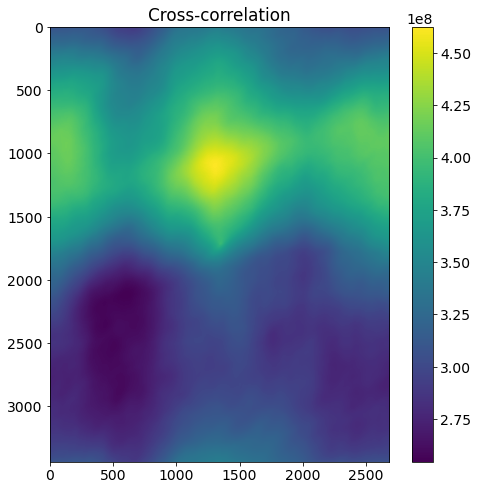

In [8]:
# NOTE: not currently applying this correction - image and DEM are georegistered

# ---------------------------------------
# -----COREGISTER: CROSS-CORRELATION-----
# ---------------------------------------

image_product = np.fft.fft2(b) * np.fft.fft2(hs_resamp_smooth).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))

# cross-correlate
# xc = correlate2d(hs_resamp_smooth, b)
# lags_x = np.arange(-len(im_x)/2, len(im_x)/2)
# lags_y = np.arange(-len(im_y)/2, len(im_y)/2)

# plot
fig3 = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 14, 'font.serif': 'Arial'})
plt.rcParams.update({'font.size': 14, 'font.serif': 'Arial'})
plt.imshow(cc_image.real)
plt.title("Cross-correlation")
plt.colorbar()
plt.show()

## 5. Determine optimal band scalars for correction, apply image correction

In [9]:
# -----------------------------
# -----NORMALIZE HILLSHADE-----
# -----------------------------

# -----normalize hillshade model
hs_norm = (hs_resamp_smooth - np.min(hs_resamp_smooth)) / (np.max(hs_resamp_smooth) - np.min(hs_resamp_smooth))
hs_SCA_norm = (hs_SCA - np.min(hs_SCA)) / (np.max(hs_SCA) - np.min(hs_SCA))

# ----------------------------------------
# -----LOOP THROUGH HILLSHADE SCALARS-----
# ----------------------------------------

# -----loop through hillshade scalar multipliers
# define scalars to test
hs_scalars = np.linspace(0,0.5,num=21)
# blue
b_SCA_mu = [] # mean 
b_SCA_std = [] # std
# green
g_SCA_mu = [] # mean 
g_SCA_std = [] # std
# red
r_SCA_mu = [] # mean 
r_SCA_std = [] # std
# nir
nir_SCA_mu = [] # mean 
nir_SCA_std = [] # std
count=0
for hs_scalar in hs_scalars:
    # full image
    b_adj = b - (hs_norm * hs_scalar)
    g_adj = g - (hs_norm * hs_scalar)
    r_adj = r - (hs_norm * hs_scalar)
    nir_adj = nir - (hs_norm * hs_scalar)
    # SCA
    b_SCA_mu = b_SCA_mu + [np.nanmean(b_SCA - (hs_SCA_norm * hs_scalar))]
    b_SCA_std = b_SCA_std + [np.nanstd(b_SCA - (hs_SCA_norm * hs_scalar))] 
    g_SCA_mu = g_SCA_mu + [np.nanmean(g_SCA - (hs_SCA_norm * hs_scalar))]
    g_SCA_std = g_SCA_std + [np.nanstd(g_SCA - (hs_SCA_norm * hs_scalar))]
    r_SCA_mu = r_SCA_mu + [np.nanmean(r_SCA - (hs_SCA_norm * hs_scalar))]
    r_SCA_std = r_SCA_std + [np.nanstd(r_SCA - (hs_SCA_norm * hs_scalar))]
    nir_SCA_mu = nir_SCA_mu + [np.nanmean(nir_SCA - (hs_SCA_norm * hs_scalar))]
    nir_SCA_std = nir_SCA_std + [np.nanstd(nir_SCA - (hs_SCA_norm * hs_scalar))]
    # plot full image bands
#     fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(18,6), facecolor='w')
#     plt.rcParams.update({'font.size': 12, 'font.serif': 'Arial'})
#     fig.suptitle('Scalar = '+str(np.around(hs_scalar, decimals=2)))
#     ax1.imshow(b_adj, extent=(np.min(im_x)/1000, np.max(im_x)/1000, np.min(im_y)/1000, np.max(im_y)/1000), 
#                cmap='Blues_r', vmin=0, vmax=1)
#     ax1.set_ylabel('Northing [km]')
#     ax1.set_xlabel('Easting [km]')
#     ax1.set_title('Blue')
#     ax2.imshow(g_adj, extent=(np.min(im_x)/1000, np.max(im_x/1000), np.min(im_y)/1000, np.max(im_y)/1000), 
#                cmap='Greens_r', vmin=0, vmax=1)
#     ax2.set_xlabel('Easting [km]')
#     ax2.set_title('Green')
#     ax3.imshow(r_adj, extent=(np.min(im_x/1000), np.max(im_x)/1000, np.min(im_y)/1000, np.max(im_y)/1000), 
#                cmap='Reds_r', vmin=0, vmax=1)
#     ax3.set_xlabel('Easting [km]')
#     ax3.set_title('Red')
#     ax4.imshow(nir_adj, extent=(np.min(im_x)/1000, np.max(im_x)/1000, np.min(im_y)/1000, np.max(im_y)/1000), 
#                cmap='Purples_r', vmin=0, vmax=1)
#     ax4.set_xlabel('Easting [km]')
#     ax4.set_title('NIR')
#     fig.tight_layout()
#     plt.show()
#     fig.savefig(results_path+str(count)+'.png', dpi=250,
#                 facecolor=fig.get_facecolor())
#     print('figure saved')
    count+=1

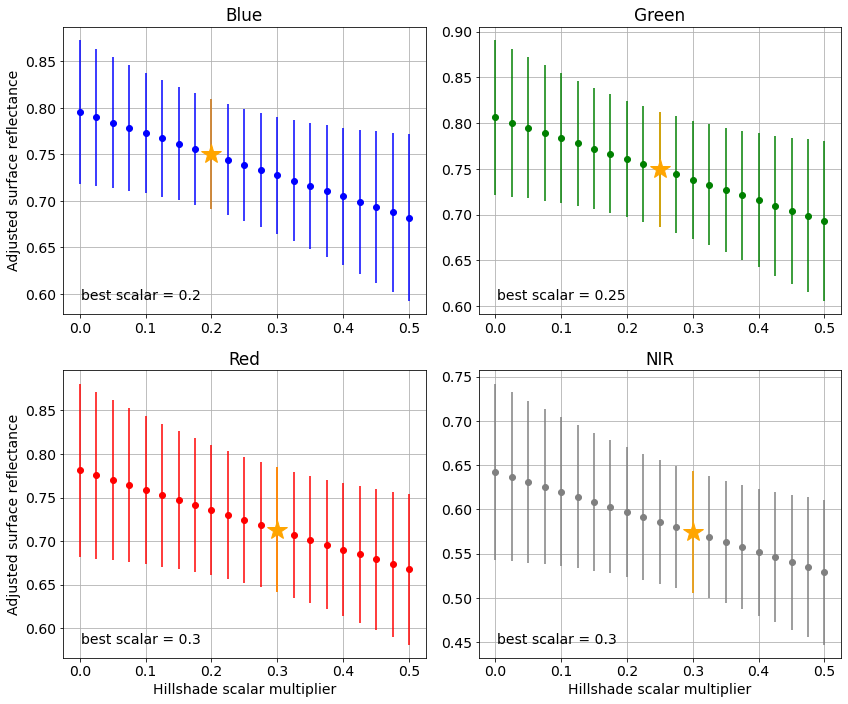

In [10]:
# -------------------------
# -----DISPLAY RESULTS-----
# -------------------------

# -----plot mean & std results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10))
plt.rcParams.update({'font.size': 14, 'font.serif': 'Arial'})
# blue
ax1.errorbar(hs_scalars, b_SCA_mu, b_SCA_std, fmt='o', color='b', label='blue')
Ib = np.where(b_SCA_std==np.min(b_SCA_std))[0][0] # optimal scalar index
ax1.errorbar(hs_scalars[Ib], b_SCA_mu[Ib], b_SCA_std[Ib], fmt='*', ms=20, color='orange')
ax1.text((ax1.get_xlim()[1] - ax1.get_xlim()[0])*0.05 + ax1.get_xlim()[0], 
         (ax1.get_ylim()[1] - ax1.get_ylim()[0])*0.05 + ax1.get_ylim()[0], 
         'best scalar = '+str(np.round(hs_scalars[Ib],decimals=2)))
ax1.grid()
ax1.set_title('Blue')
ax1.set_ylabel('Adjusted surface reflectance')
# green
ax2.errorbar(hs_scalars, g_SCA_mu, g_SCA_std, fmt='o', color='g', label='green')
Ig = np.where(g_SCA_std==np.min(g_SCA_std))[0][0] # optimal scalar index
ax2.errorbar(hs_scalars[Ig], g_SCA_mu[Ig], g_SCA_std[Ig], fmt='*', ms=20, color='orange')
ax2.text((ax2.get_xlim()[1] - ax2.get_xlim()[0])*0.05 + ax2.get_xlim()[0], 
         (ax2.get_ylim()[1] - ax2.get_ylim()[0])*0.05 + ax2.get_ylim()[0], 
         'best scalar = '+str(np.round(hs_scalars[Ig],decimals=2)))
ax2.set_title('Green')
ax2.grid()
# red
ax3.errorbar(hs_scalars, r_SCA_mu, r_SCA_std, fmt='o', color='r', label='red')
Ir = np.where(r_SCA_std==np.min(r_SCA_std))[0][0] # optimal scalar index
ax3.errorbar(hs_scalars[Ir], r_SCA_mu[Ir], r_SCA_std[Ir], fmt='*', ms=20, color='orange')
ax3.text((ax3.get_xlim()[1] - ax3.get_xlim()[0])*0.05 + ax3.get_xlim()[0], 
         (ax3.get_ylim()[1] - ax3.get_ylim()[0])*0.05 + ax3.get_ylim()[0], 
         'best scalar = '+str(np.round(hs_scalars[Ir],decimals=2)))
ax3.set_title('Red')
ax3.set_ylabel('Adjusted surface reflectance')
ax3.set_xlabel('Hillshade scalar multiplier')
ax3.grid()
# NIR
ax4.errorbar(hs_scalars, nir_SCA_mu, nir_SCA_std, fmt='o', color='grey', label='NIR')
Inir = np.where(nir_SCA_std==np.min(nir_SCA_std))[0][0] # optimal scalar index
ax4.errorbar(hs_scalars[Inir], nir_SCA_mu[Inir], nir_SCA_std[Inir], fmt='*', ms=20, color='orange')
ax4.text((ax4.get_xlim()[1] - ax4.get_xlim()[0])*0.05 + ax4.get_xlim()[0], 
         (ax4.get_ylim()[1] - ax4.get_ylim()[0])*0.05 + ax4.get_ylim()[0], 
         'best scalar = '+str(np.round(hs_scalars[Inir],decimals=2)))
ax4.set_title('NIR')
ax4.set_xlabel('Hillshade scalar multiplier')
ax4.grid()
fig.tight_layout()
plt.show()

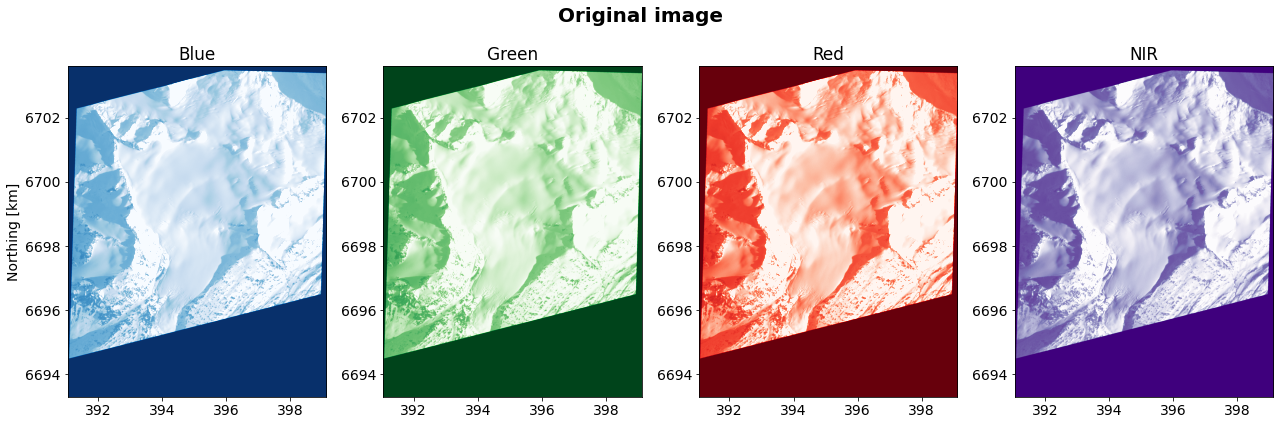

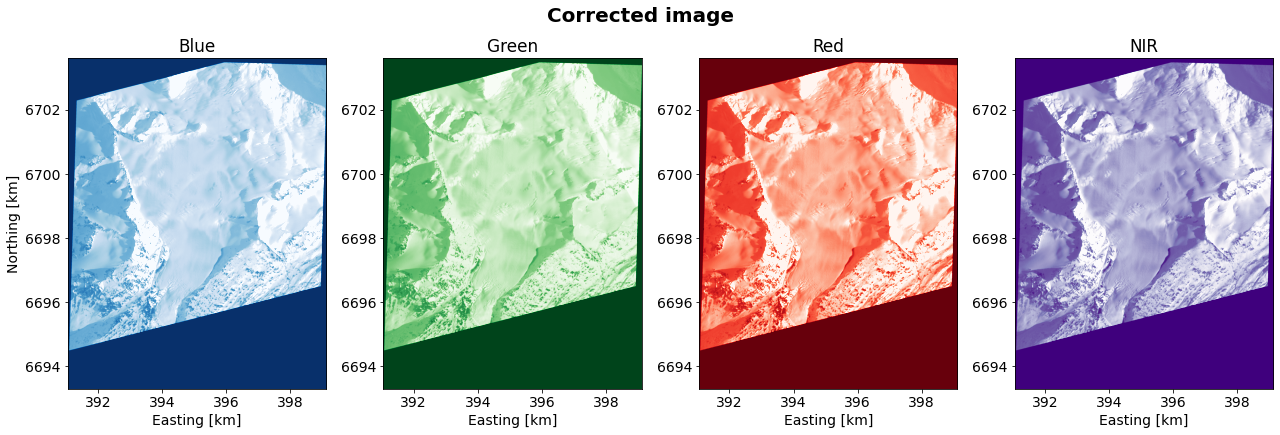

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


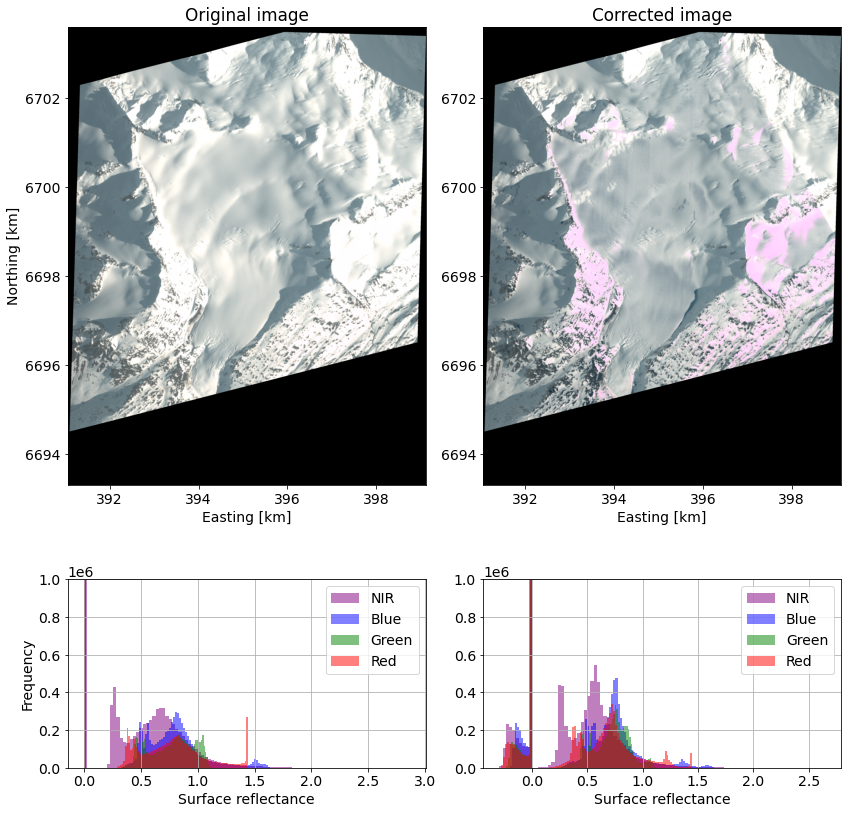

In [11]:
# --------------------------------
# -----APPLY RESULTS TO IMAGE-----
# --------------------------------

# -----apply optimal hillshade correction
b_corrected = b - (hs_norm * hs_scalars[Ib])
g_corrected = g - (hs_norm * hs_scalars[Ig])
r_corrected = r - (hs_norm * hs_scalars[Ir])
nir_corrected = nir - (hs_norm * hs_scalars[Inir])

# -----normalize bands from 0 to 1
b_corrected_norm = (b_corrected - np.min(b_corrected)) / (np.max(b_corrected) - np.min(b_corrected))
g_corrected_norm = (g_corrected - np.min(g_corrected)) / (np.max(g_corrected) - np.min(g_corrected))
r_corrected_norm = (r_corrected - np.min(r_corrected)) / (np.max(r_corrected) - np.min(r_corrected))
nir_corrected_norm = (nir_corrected - np.min(nir_corrected)) / (np.max(nir_corrected) - np.min(nir_corrected))

# -----plot each band
# original image
fig1, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(18,6))
plt.rcParams.update({'font.size': 14, 'font.serif': 'Arial'})
fig1.suptitle('Original image', fontsize=20, fontweight='bold')
ax1.imshow(b, extent=(np.min(im_x)/1000, np.max(im_x)/1000, np.min(im_y)/1000, np.max(im_y)/1000), 
           cmap='Blues_r', vmin=0, vmax=1)
ax1.set_ylabel('Northing [km]')
ax1.set_title('Blue')
ax2.imshow(g, extent=(np.min(im_x)/1000, np.max(im_x/1000), np.min(im_y)/1000, np.max(im_y)/1000), 
           cmap='Greens_r', vmin=0, vmax=1)
ax2.set_title('Green')
ax3.imshow(r, extent=(np.min(im_x/1000), np.max(im_x)/1000, np.min(im_y)/1000, np.max(im_y)/1000), 
           cmap='Reds_r', vmin=0, vmax=1)
ax3.set_title('Red')
ax4.imshow(nir, extent=(np.min(im_x)/1000, np.max(im_x)/1000, np.min(im_y)/1000, np.max(im_y)/1000), 
           cmap='Purples_r', vmin=0, vmax=1)
ax4.set_title('NIR')
fig1.tight_layout()
# corrected image
fig2, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(18,6))
fig2.suptitle('Corrected image', fontsize=20, fontweight='bold')
ax1.imshow(b_corrected, extent=(np.min(im_x)/1000, np.max(im_x)/1000, np.min(im_y)/1000, np.max(im_y)/1000), 
           cmap='Blues_r', vmin=0, vmax=1)
ax1.set_ylabel('Northing [km]')
ax1.set_xlabel('Easting [km]')
ax1.set_title('Blue')
ax2.imshow(g_corrected, extent=(np.min(im_x)/1000, np.max(im_x/1000), np.min(im_y)/1000, np.max(im_y)/1000), 
           cmap='Greens_r', vmin=0, vmax=1)
ax2.set_xlabel('Easting [km]')
ax2.set_title('Green')
ax3.imshow(r_corrected, extent=(np.min(im_x/1000), np.max(im_x)/1000, np.min(im_y)/1000, np.max(im_y)/1000), 
           cmap='Reds_r', vmin=0, vmax=1)
ax3.set_xlabel('Easting [km]')
ax3.set_title('Red')
ax4.imshow(nir_corrected, extent=(np.min(im_x)/1000, np.max(im_x)/1000, np.min(im_y)/1000, np.max(im_y)/1000), 
           cmap='Purples_r', vmin=0, vmax=1)
ax4.set_xlabel('Easting [km]')
ax4.set_title('NIR')
fig2.tight_layout()
# corrected image
plt.show()

# -----plot RGB and band histograms
# RGB images
fig3, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12), gridspec_kw={'height_ratios': [3, 1]})
ax1.imshow(np.dstack([r, g, b]), 
           extent=(np.min(im_x)/1000, np.max(im_x/1000), np.min(im_y)/1000, np.max(im_y)/1000))
ax1.set_xlabel('Easting [km]')
ax1.set_ylabel('Northing [km]')
ax1.set_title('Original image')
ax2.imshow(np.dstack([r_corrected, g_corrected, b_corrected]), 
           extent=(np.min(im_x)/1000, np.max(im_x/1000), np.min(im_y)/1000, np.max(im_y)/1000))
ax2.set_xlabel('Easting [km]')
ax2.set_title('Corrected image')
# band histograms
ax3.hist(nir.flatten(), bins=100, color='purple', alpha=0.5, label='NIR')
ax3.hist(b.flatten(), bins=100, color='blue', alpha=0.5, label='Blue')
ax3.hist(g.flatten(), bins=100, color='green', alpha=0.5, label='Green')
ax3.hist(r.flatten(), bins=100, color='red', alpha=0.5, label='Red')
# ax3.set_xlim(0,1)
ax3.set_ylim(0,1e6)
ax3.grid()
ax3.legend()
ax3.set_xlabel('Surface reflectance')
ax3.set_ylabel('Frequency')
ax4.hist(nir_corrected.flatten(), bins=100, color='purple', alpha=0.5, label='NIR')
ax4.hist(b_corrected.flatten(), bins=100, color='blue', alpha=0.5, label='Blue')
ax4.hist(g_corrected.flatten(), bins=100, color='green', alpha=0.5, label='Green')
ax4.hist(r_corrected.flatten(), bins=100, color='red', alpha=0.5, label='Red')
# ax4.set_xlim(0,1)
ax4.set_ylim(0,1e6)
ax4.grid()
ax4.legend()
ax4.set_xlabel('Surface reflectance')
fig3.tight_layout()
# fig.suptitle('Probability Mass Functions')
plt.show()

/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_5779/3791281611.py:3: RuntimeWarning: invalid value encountered in true_divide
  NDSI_original = (nir-g) / (nir+g)
/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_5779/3791281611.py:4: RuntimeWarning: invalid value encountered in true_divide
  NDSI_corrected = (nir_corrected-g_corrected) / (nir_corrected+g_corrected)


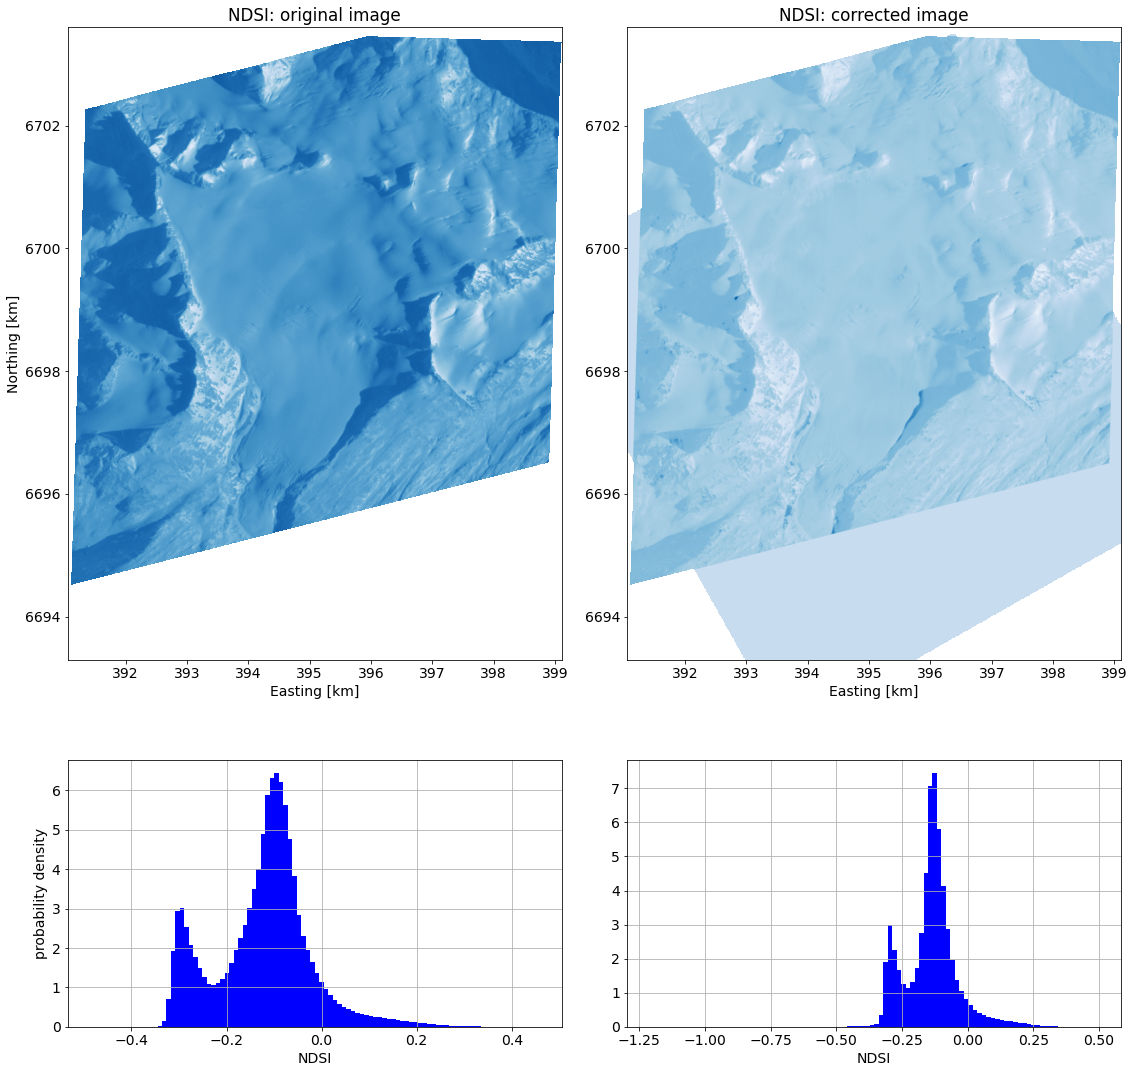

In [12]:
# -----plot modified NDSI

NDSI_original = (nir-g) / (nir+g)
NDSI_corrected = (nir_corrected-g_corrected) / (nir_corrected+g_corrected)

fig3, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,16), gridspec_kw={'height_ratios': [3, 1]})
plt.rcParams.update({'font.size': 14, 'font.serif': 'Arial'})
# original: map
ax1.imshow(NDSI_original, 
           extent=(np.min(im_x)/1000, np.max(im_x/1000), np.min(im_y)/1000, np.max(im_y)/1000),
          cmap='Blues_r')
ax1.set_xlabel('Easting [km]')
ax1.set_ylabel('Northing [km]')
ax1.set_title('NDSI: original image')
# corrected: map
ax2.imshow(NDSI_corrected, 
           extent=(np.min(im_x)/1000, np.max(im_x/1000), np.min(im_y)/1000, np.max(im_y)/1000),
          cmap='Blues_r')
ax2.set_xlabel('Easting [km]')
ax2.set_title('NDSI: corrected image')
# original: histogram
ax3.hist(NDSI_original.flatten(), density=True, color='blue', bins=100)
ax3.set_xlabel('NDSI')
ax3.set_ylabel('probability density')
ax3.grid()
# corrected: histogram
ax4.hist(NDSI_corrected[np.where(b!=0)].flatten(), density=True, color='blue', bins=100)
ax4.set_xlabel('NDSI')
ax4.grid()
fig3.tight_layout()
plt.show()